In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 2
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonfly, and my name is Dragonfly, so I'm also a dragonfly! I'm a dragonfly with the ability to fly, which means I can fly!

I've always wanted to be a dragonfly, and this was one of the most exciting experiences of my life. I loved playing with my friends and playing with my family, but I was a little nervous about my friends, and I didn't like them. I was so scared to fly, so I tried to figure out how to fly! I'm a dragonfly with a unique ability to fly, so I decided


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>park2<msg>Ry "How would a murderer like Reza be dealt with? An eye for an eye?"<|endoftext|><p><msg>c "Grilled. Unless prepared properly, raw meat carries a significant risk of diseases for us."<|endoftext|><p><msg>c "Feel free, though I'm not sure if there's anything special about it."<d><scn>o2<msg>m "I watched with amusement as Bryce headed for the kitchen."<|endoftext|><d><scn>np2x<msg>Ad "Are you going to come back?"<|endoftext|><
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


 the police station. Me, Sebastian, Maverick, Naomi - the bond we form on the job is how we know to look out for each other."<|endoftext|><p><msg>c "Fight Bryce"<d><scn>o2<msg>m "I didn't hesitate and kicked Bryce right in the stomach"<|endoftext|><d><scn>facin3<msg>Lo "He sounded very emotional, which is very unusual for him."<|endoftext|><d><scn>park3<msg>Br "I have no way of knowing that, Minister."<|endoftext|><p><msg>c "I'm
 serious. Let's just forget it and focus on today."<d><scn>o2<msg>Br "Alright."<|endoftext|><d><scn>black<msg>Br "I didn't say that."<|endoftext|><p><msg>c "Of course."<|endoftext|><d><scn>office<msg>Sb "You did great today, [player_name]. The police department is glad to have you on our side."<|endoftext|><p><msg>c "Come on. Let's get you home, you big wuss."<|endoftext|><d><scn>black<msg>Ry "


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
2,4.549900
4,4.566100
6,4.275800
8,3.926700
10,3.482900
12,3.335700
14,2.968200
16,2.753600
18,2.542500
20,2.393100


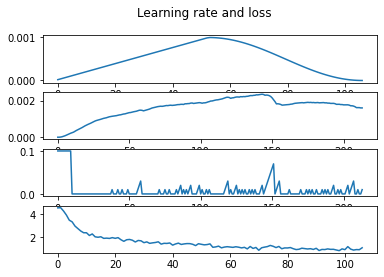

In [9]:
fig, axs = plt.subplots(4)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['mix_rate'])
axs[3].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 1.39 MiB/s, done.
Using framework PyTorch: 1.10.1+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTor

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragoness who has been sent to the portal. As I approach the portal, I see dragons in their natural form, with horns and wings that are covered in scales. As I approach the portal, I see dragons in their natural form, with horns and wings that are covered in scales."<|endoftext|>
PyTorch: In my dreams, I'm a dragoness."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragoness who has been sent to the portal. As I approach the portal, I see dragons in their natural form, with horns, wings, and horns that are almost as long as their wings. They are very similar to humans, with a few differences."<d><scn name>black>black<p><msg>c "(I guess I should be going now, then.)"c "I'll be back."<|endoftext|>
PyTorch: In my dreams, I'm a dragon. I've seen dragons in action. I can take photos of myself with these abilities."<d><scn>loremapt<msg>Lo "That's a very weird question, [pla

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon. As such, I can call myself a dragon."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "Good to hear. I'll see you next time."<d><scn>park2<msg>Ry "I see. Well, I know I haven't exactly been up to date in regards to Reza's sudden disappearance, but to get the message today that he is a confirmed serial killer was quite shocking."<d><scn>park2<msg>Ry "Yes


Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I don't know. He seems a little different."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "I


Prompt: Oh my god, Adine. What is this?
Reply: park2<msg>Ry "I don't know. I suppose I should be going now."<d><scn>park2<msg>Ry "I see. Well, I know I haven't exactly been up to date in regards to Reza's sudden disappearance, but to get the message today that he is a confirmed serial killer was quite shocking."<d><scn>park2<msg>


Prompt: What will we do here?
Reply: facin2<msg>An "We'll see how it goes."<p><msg>c "I don't know."<d><

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-" * 10)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Pretty good, thanks."<p><msg>c "And that's all?"<d><scn>park2<msg>Ry "Sure, but I still feel like I know a lot more about your kind than you do."<d><scn>park2<msg>Ry "Well, that's actually more helpful than you might think. If you think about it

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Well, I'm not taking any visitors right now, so I'll just have to be careful."<d><scn>park2<msg>Ad "If you say so."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."<p

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: park3<msg>Adine "I see. Well, it's a little late for that, but I suppose you could say so."<p><msg>c "Oh, really? That's a shame."<d><scn>park3<msg>Adine "I don't like them very much."<d><scn>park3<msg>Adine "You don't like

[Test 1] -> Prompt: What will we do here?
Reply: cafe<msg>An "First up is the question: What will it be?"<p><msg>c "Meet with Reza"<d><scn>reza

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'[Pytorch] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print(f'[ONNX] {rp} -> {onnx_model_manager.say("", rp, do_sample = True)}')
    print("-" * 10)

[Pytorch] Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
[ONNX] Visit Lorem -> loremapt<msg>Lo "Hey [ad]!"<d><scn>loremapt<msg>Ip "Hey Lorem, what can you tell us?"<d><scn>loremapt<msg>Lo "This is Lorem, the author of the game you played last night."<d><scn>loremapt<msg>Ip "Yes."<d><scn>loremapt<msg>Lo "Here, what can I bring you?"<d><scn>loremapt<msg>Ip "Let me take a seat. You
----------
[Pytorch] Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
[ONNX] Meet with Lorem -> loremapt<msg>Lo "Hey [ad] [playlist]!"<|endoftext|>
----------
[Pytorch] Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
[ONNX] Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I wasn't sure whether I'd get a spot in a room filled with the likes of you."<|endoftext|>
----------
[Pytorch] Fight Maverick -> black<msg>m "When I arrived at the station, I was met by the police archivist, a police detective. She was the one w